#### 1. Implementing XGBoost Algorithm

In [123]:
#🧩 Step 1: Load the Scaled Dataset

In [124]:
import pandas as pd

# Load the scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')

In [125]:
# Display first few rows
df.head()

,Age,Pulse Rate,Systolic Pressure,Diastolic Pressure,Respiratory Rate,Temperature,Weight,BMI,Total Cholesterol,Risk Factor_Dyslamapedia,...,Musculoskeletal System_Yes,Diagnosis_Endocrine Disorders,Diagnosis_Infectious Diseases,Diagnosis_Surgical Conditions,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,CVD_Yes
0,-0.220730,-0.632570,-0.675769,-0.181866,0.250619,-0.296989,-2.646255,-1.747322,-0.089204,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,-0.451464,-0.442924,False
1,-1.692960,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,0.015068,-1.747322,2.012453,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
2,-0.017664,1.094266,1.819467,1.775250,2.721419,4.875546,0.015068,-1.747322,0.141115,-0.719817,...,-0.624402,1.441931,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
3,0.693068,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,-2.625571,-1.721482,0.515383,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,-0.445237,-0.444544,-0.451464,2.257724,True
4,0.439235,0.687951,-0.546705,-0.181866,0.250619,-0.167676,-2.797936,-1.682720,-0.808949,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,2.215016,-0.442924,False


In [ ]:
#🧩 Step 2: Split Features and Target
# Separate features (X) and target variable (y)
X = df.drop('CVD_Yes', axis=1)  
y = df['CVD_Yes']

In [128]:
#🧩 Step 3: Split into Training and Test Sets
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#### Define the Model

In [132]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define the base model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',  # You can also try 'accuracy' or 'roc_auc'
    verbose=1,
    n_jobs=-1
)

# Fit GridSearch to the training data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters Found:")
print(grid_search.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


#### Train the Model

In [133]:
# Train XGBoost with best parameters
best_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

best_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Model Prediction

In [158]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict on test data
y_pred = best_model.predict(X_test)

# If best_model doesn't output probabilities, use predict_proba (for AUC-ROC)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (CVD Yes)

# Map numeric labels to meaningful class names (if 1 = CVD Yes, 0 = CVD No)
target_names = ['CVD No', 'CVD Yes']

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(accuracy, 3))
print("AUC-ROC:", round(auc_roc, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.874
AUC-ROC: 0.955

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.91      0.82      0.86      2044
     CVD Yes       0.84      0.93      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.88      0.87      0.87      4186
weighted avg       0.88      0.87      0.87      4186



#### Visualizing Classification Report

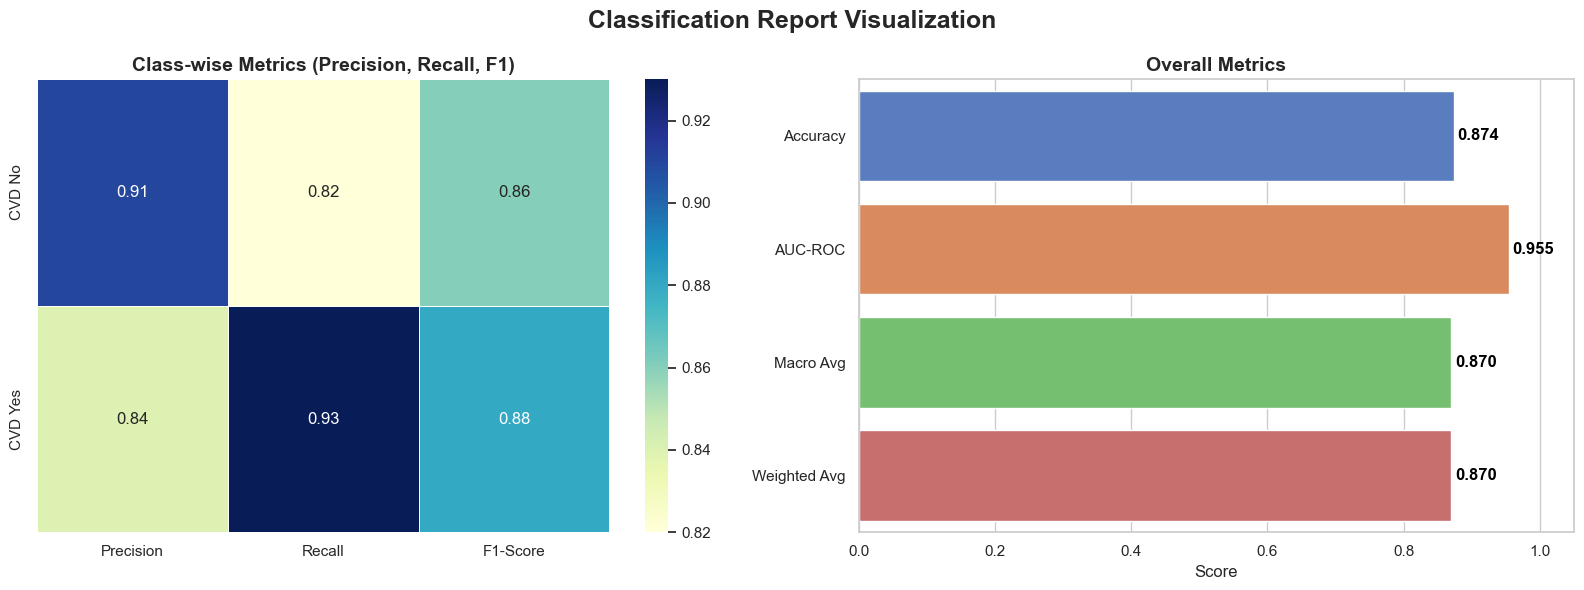

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define classification metrics manually (based on your output)
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.91, 0.84],
    'Recall': [0.82, 0.93],
    'F1-Score': [0.86, 0.88]
}

# Convert to DataFrame
class_df = pd.DataFrame(metrics_data)

# Overall metrics including AUC-ROC
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.874, 0.955, 0.87, 0.87]  # Rounded to 3 decimals
}
overall_df = pd.DataFrame(overall_metrics)

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Classification Report Visualization", fontsize=18, fontweight='bold')

# --- Heatmap for Class Metrics ---
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# --- Bar Chart for Overall Metrics ---
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2)

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold')

ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold')
ax2.set_xlabel('Score')
ax2.set_ylabel('')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Ploating Confussion Matrics

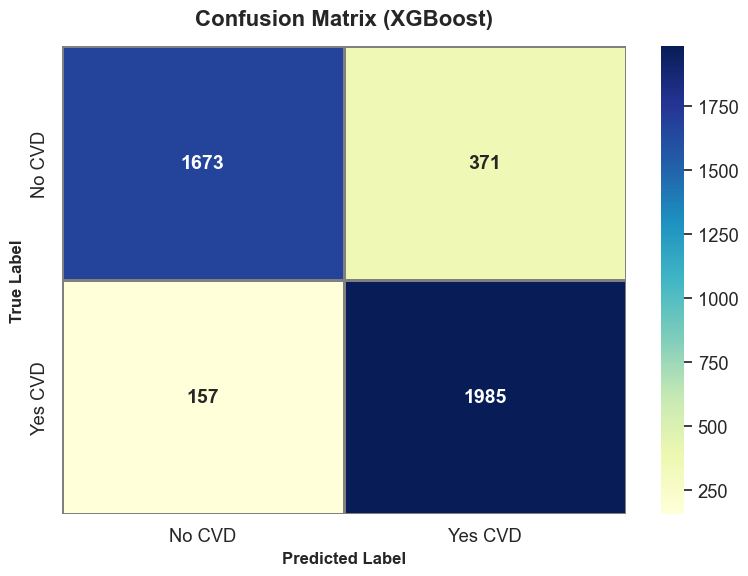

In [153]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No CVD', 'Yes CVD']

# Plot with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='gray', annot_kws={"size": 14, "weight": "bold"})

# Customize labels and title
plt.title('Confusion Matrix (XGBoost)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

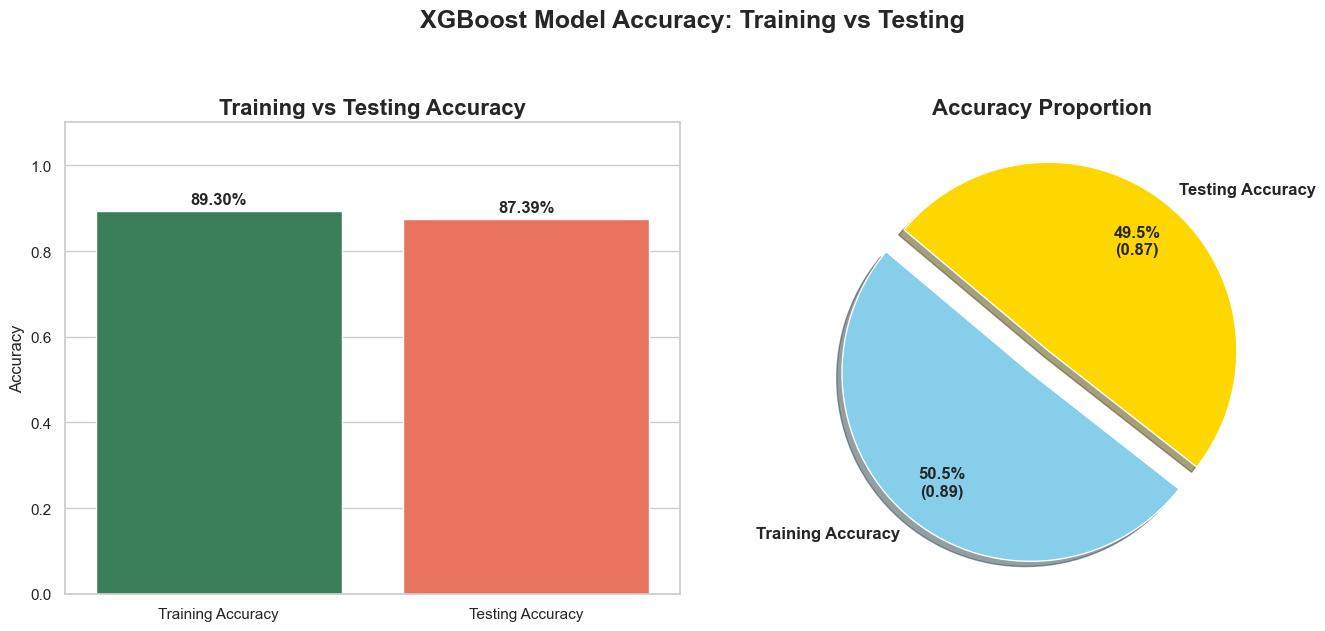

In [139]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate training and testing accuracy
train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, best_model.predict(X_test))

# Create DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc, test_acc]
})

# Define custom color palette
bar_colors = ['#2E8B57', '#FF6347']  # Green and Tomato
pie_colors = ['#87CEEB', '#FFD700']  # Sky Blue and Gold
explode = (0.1, 0.05)  # Explode slices for emphasis

# Custom autopct function to show percentage and actual value
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# --- Bar Chart ---
sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette=bar_colors, ax=axes[0])

# Add text labels to bars
for index, row in acc_df.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

# Customize bar chart
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# --- Pie Chart ---
axes[1].pie(
    acc_df['Accuracy'],
    labels=acc_df['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion', fontsize=16, fontweight='bold')

# Add a common title for the figure
fig.suptitle('XGBoost Model Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()


#### Model Interpretablity SHAP

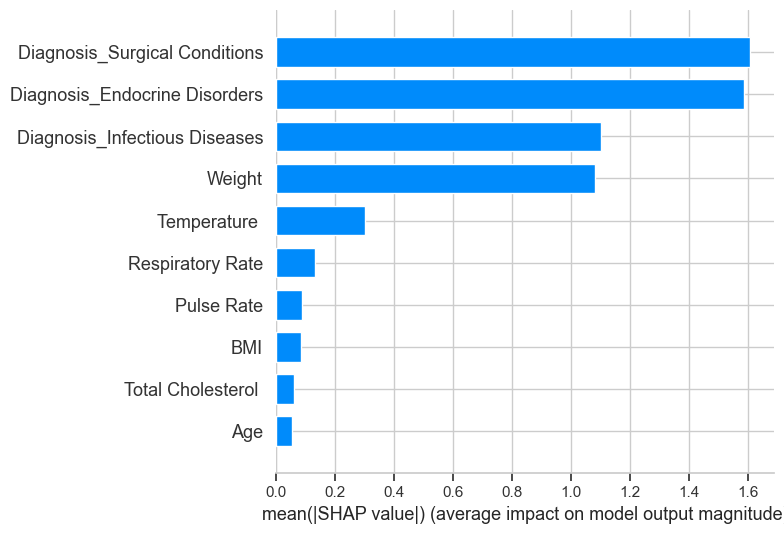

In [163]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Ensure X_train is a pandas DataFrame with feature names
# If X_train is a numpy array, convert it:
# X_train = pd.DataFrame(X_train, columns=feature_names)

# Create SHAP explainer for your XGBoost model
explainer = shap.Explainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot SHAP summary bar plot of top 10 features
shap.summary_plot(shap_values, X_train, max_display=10, plot_type='bar')


#### Model Interpretablity Using LIME

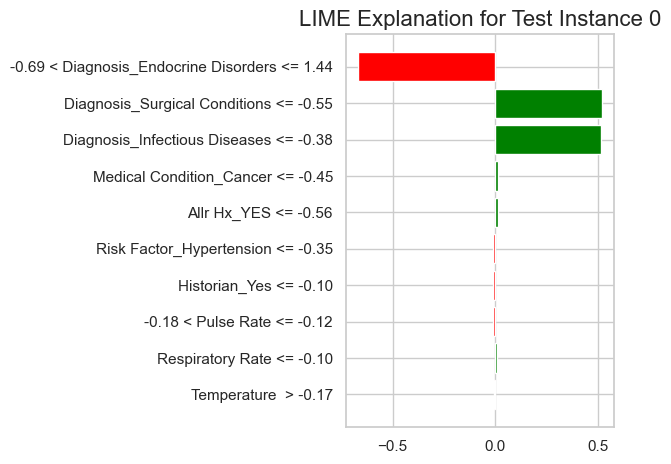

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from IPython.display import display  # Correct import for display

# Assuming you already have:
# - best_model trained (XGBoost)
# - X_train, X_test as numpy arrays or pandas DataFrames
# - y_train, y_test as arrays/series

# Example: Use first test instance to explain prediction
i = 0
instance = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]

# If X_train is a DataFrame, extract feature names and class names
feature_names = X_train.columns.tolist() if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
class_names = ['CVD No', 'CVD Yes']

# Create LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Get explanation for the instance (convert to numpy if DataFrame)
exp = explainer.explain_instance(
    data_row=np.array(instance),
    predict_fn=best_model.predict_proba,
    num_features=10
)


# Or save the explanation as HTML file
# exp.save_to_file('lime_explanation.html')

# Plot explanation as bar chart (matplotlib)
fig = exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Test Instance {i}', fontsize=16)
plt.tight_layout()
plt.show()


#### 2. Implementing Deep Random Forest Algorithm

In [2]:
## Step 1: Load dataset and spliting
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')

# Define features and target
X = df.drop(columns=['CVD_Yes'])
y = df['CVD_Yes']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [3]:
# Step 2: Hyperparameter tuning with RandomizedSearchCV for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, verbose=2)

In [4]:
## Step 3: Train the best model from hyperparameter tuning
print("Best hyperparameters:", random_search.best_params_)

best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
#save the model
import joblib  
joblib.dump(best_rf, 'best_random_forest_model.pkl')


Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


['best_random_forest_model.pkl']

In [5]:
## Step 4: Predict and evaluate (Accuracy, AUC-ROC, Classification Report)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # probabilities for positive class

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes']))


Accuracy: 0.8683707596751075
AUC-ROC: 0.9493041508840981

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.90      0.83      0.86      2044
     CVD Yes       0.85      0.91      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.87      0.87      0.87      4186
weighted avg       0.87      0.87      0.87      4186



#### Visualizing Classification Report

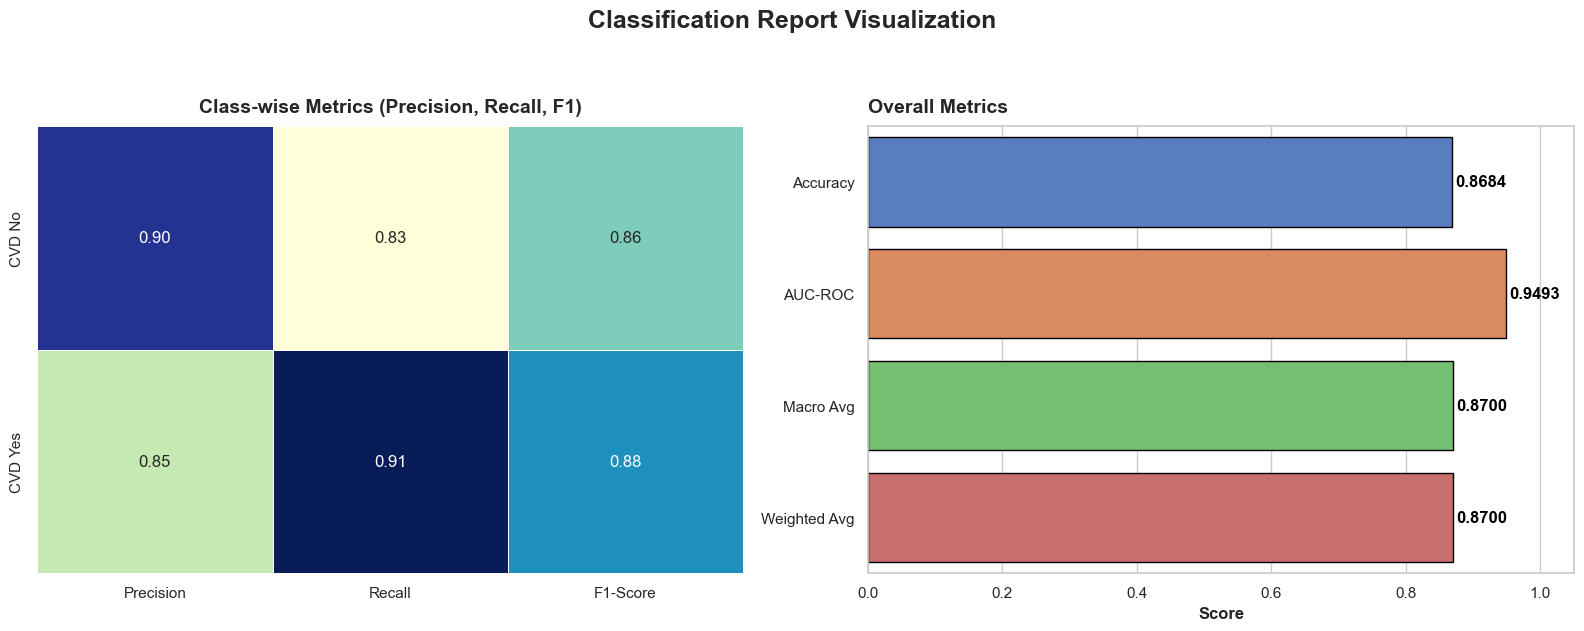

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Define classification metrics manually based on your output
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.90, 0.85],
    'Recall': [0.83, 0.91],
    'F1-Score': [0.86, 0.88]
}

# Convert to DataFrame
class_df = pd.DataFrame(metrics_data)

# Overall metrics including AUC-ROC
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.8684, 0.9493, 0.87, 0.87]  # Rounded to 4 decimals
}
overall_df = pd.DataFrame(overall_metrics)

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
# Set a common title for the figure
fig.suptitle("Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# --- Heatmap for Class Metrics ---
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1, cbar=False)
# Add labels to heatmap
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# --- Bar Chart for Overall Metrics ---
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.4f}", color='black', va='center', fontweight='bold', fontsize=12)
# Customize bar chart
ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold', pad=10, loc='left')
# Set labels
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

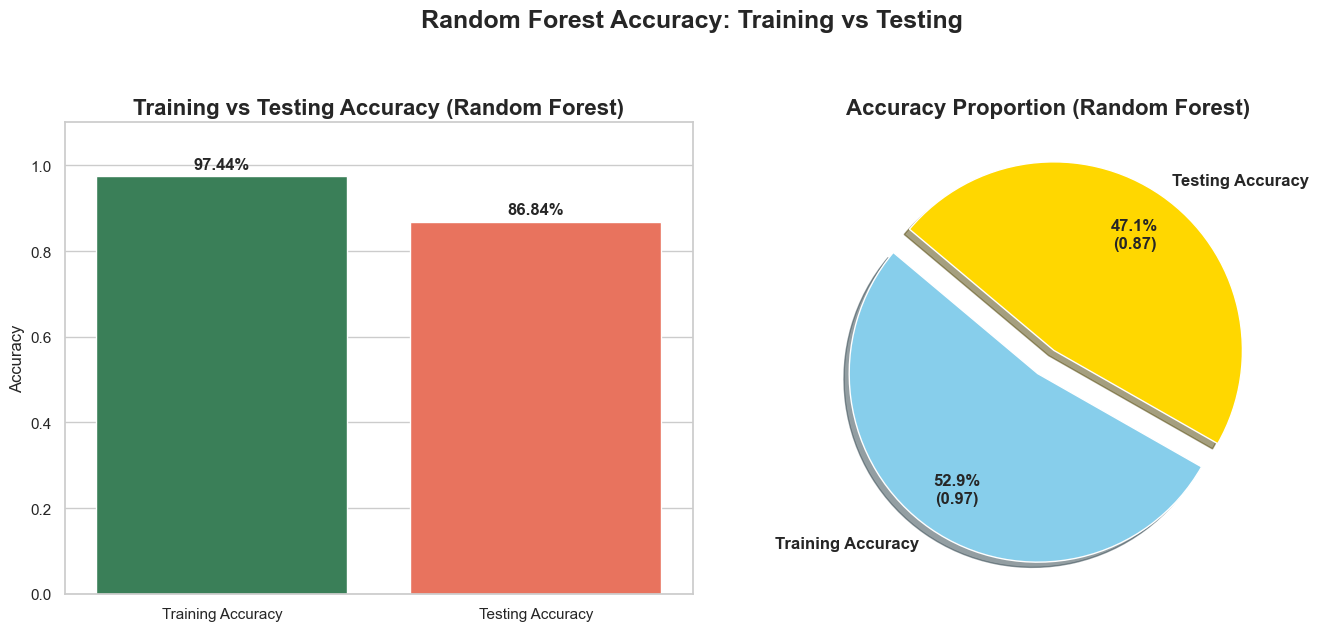

In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate training and testing accuracy for best_rf
train_acc = accuracy_score(y_train, best_rf.predict(X_train))
test_acc = accuracy_score(y_test, best_rf.predict(X_test))

# Create DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc, test_acc]
})

# Define custom color palette
bar_colors = ['#2E8B57', '#FF6347']  # Green and Tomato
pie_colors = ['#87CEEB', '#FFD700']  # Sky Blue and Gold
explode = (0.1, 0.05)  # Explode slices for emphasis

# Custom autopct function to show percentage and actual value
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# --- Bar Chart ---
sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette=bar_colors, ax=axes[0])

# Add text labels to bars
for index, row in acc_df.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

# Customize bar chart
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy (Random Forest)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# --- Pie Chart ---
axes[1].pie(
    acc_df['Accuracy'],
    labels=acc_df['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion (Random Forest)', fontsize=16, fontweight='bold')

# Add a common title for the figure
fig.suptitle('Random Forest Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()


#### Model Interpretablity Using SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ Convert X_train to DataFrame if needed
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=feature_names)

# ✅ SHAP Explainer
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_train)

# ✅ Compute Information Gain-based importances (from Random Forest)
info_gain_importances = best_rf.feature_importances_
info_gain_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': info_gain_importances
}).sort_values(by='Importance', ascending=False).head(10)

# ✅ SHAP Summary Plot (Top 10)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train, max_display=10, plot_type='bar')
plt.title("Top 10 SHAP Feature Importances", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ✅ Plot Information Gain Importances
plt.figure(figsize=(12, 6))
sns.barplot(data=info_gain_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Features by Information Gain (Random Forest)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Information Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


  1%|                   | 438/33480 [00:57<71:39]       

#### Model Interpretablity Using LIME

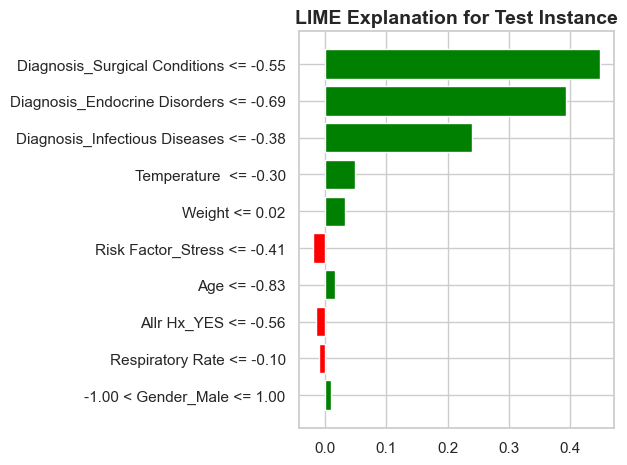

In [11]:
# Required Imports
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X_train is a DataFrame
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# Create LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=X_train_df.columns,
    class_names=['CVD No', 'CVD Yes'],
    mode='classification'
)

# Select instance to explain
i = 25  # Change index as needed
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=best_rf.predict_proba,
    num_features=10
)

# Static visualization using matplotlib
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.title("LIME Explanation for Test Instance", fontsize=14, fontweight='bold')
plt.show()


#### 3.Implementing Gradient Boosting Machine Algorithm

In [2]:
#Step 1: Load the Dataset
import pandas as pd

# Load the scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')
df.head()


,Age,Pulse Rate,Systolic Pressure,Diastolic Pressure,Respiratory Rate,Temperature,Weight,BMI,Total Cholesterol,Risk Factor_Dyslamapedia,...,Musculoskeletal System_Yes,Diagnosis_Endocrine Disorders,Diagnosis_Infectious Diseases,Diagnosis_Surgical Conditions,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,CVD_Yes
0,-0.220730,-0.632570,-0.675769,-0.181866,0.250619,-0.296989,-2.646255,-1.747322,-0.089204,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,-0.451464,-0.442924,False
1,-1.692960,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,0.015068,-1.747322,2.012453,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
2,-0.017664,1.094266,1.819467,1.775250,2.721419,4.875546,0.015068,-1.747322,0.141115,-0.719817,...,-0.624402,1.441931,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
3,0.693068,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,-2.625571,-1.721482,0.515383,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,-0.445237,-0.444544,-0.451464,2.257724,True
4,0.439235,0.687951,-0.546705,-0.181866,0.250619,-0.167676,-2.797936,-1.682720,-0.808949,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,2.215016,-0.442924,False


In [3]:
# Step 2: Prepare Features and Target
# Define features and target
X = df.drop(columns=['CVD_Yes'])  # Drop target column
y = df['CVD_Yes']

# Check shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (20926, 26)
Target shape: (20926,)


In [4]:
# Step 3: Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split

# Split into training and testing data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 16740
Testing samples: 4186


In [5]:
# Step 4: Hyperparameter Tuning with GridSearchCV for GBM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate GBM classifier
gbm = GradientBoostingClassifier(random_state=42)

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [6]:
#Step 5: Train GBM Model with Best Parameters
# Get best estimator
best_gbm = grid_search.best_estimator_

# Fit best GBM on full training data
best_gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,
                           random_state=42)

In [7]:
# Step 6: Evaluate the Model on Test Set
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on test data
y_pred = best_gbm.predict(X_test)
y_proba = best_gbm.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("\nClassification Report:\n", report)


Accuracy: 0.8736
AUC-ROC: 0.9552

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.91      0.82      0.86      2044
     CVD Yes       0.84      0.93      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.88      0.87      0.87      4186
weighted avg       0.88      0.87      0.87      4186



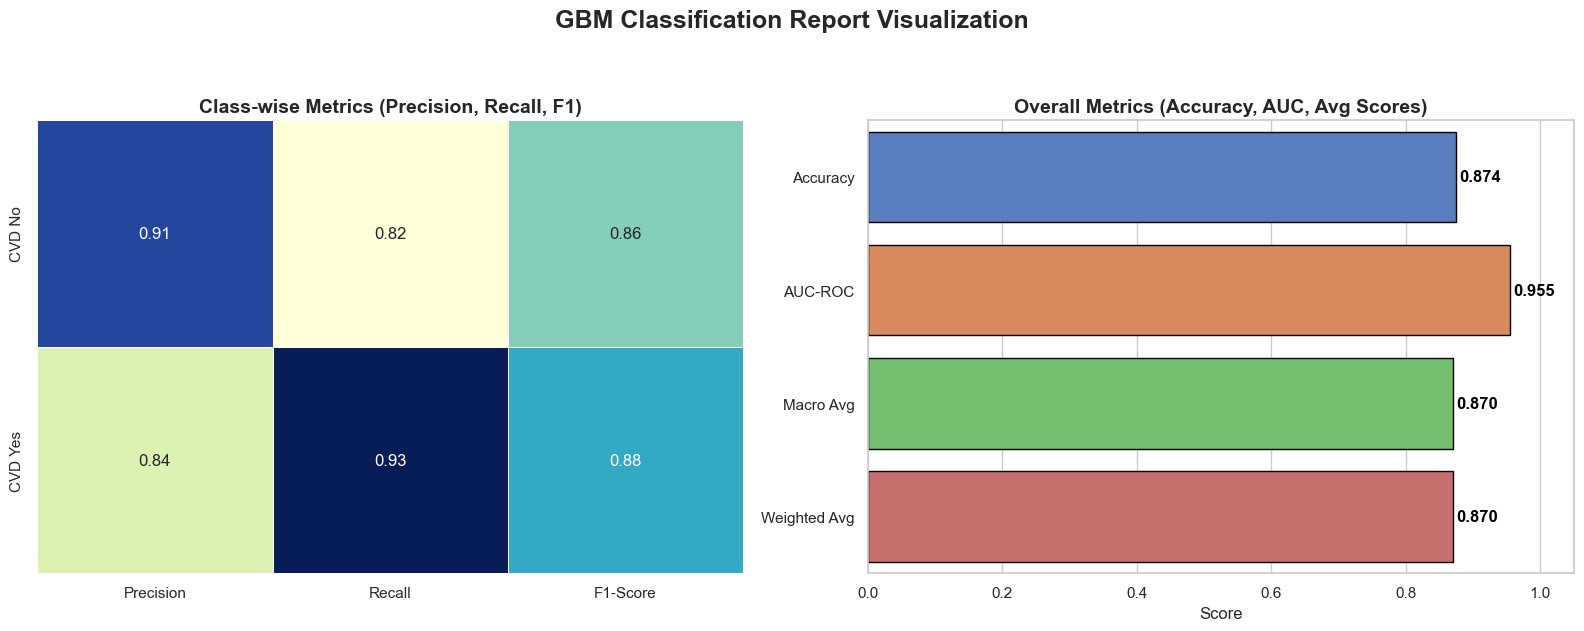

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === Class-wise Metrics ===
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.91, 0.84],
    'Recall': [0.82, 0.93],
    'F1-Score': [0.86, 0.88]
}
class_df = pd.DataFrame(metrics_data)

# === Overall Metrics ===
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.874, 0.955, 0.87, 0.87]
}
overall_df = pd.DataFrame(overall_metrics)

# === Plot Settings ===
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("GBM Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# === Heatmap for Class-wise Precision, Recall, F1 ===
sns.heatmap(
    class_df.set_index('Class'),
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    linewidths=0.5,
    ax=ax1,
    cbar=False
)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# === Bar Chart for Overall Metrics ===
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold', fontsize=12)

ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics (Accuracy, AUC, Avg Scores)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Score', fontsize=12)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


#### Ploting Confussion Matrics

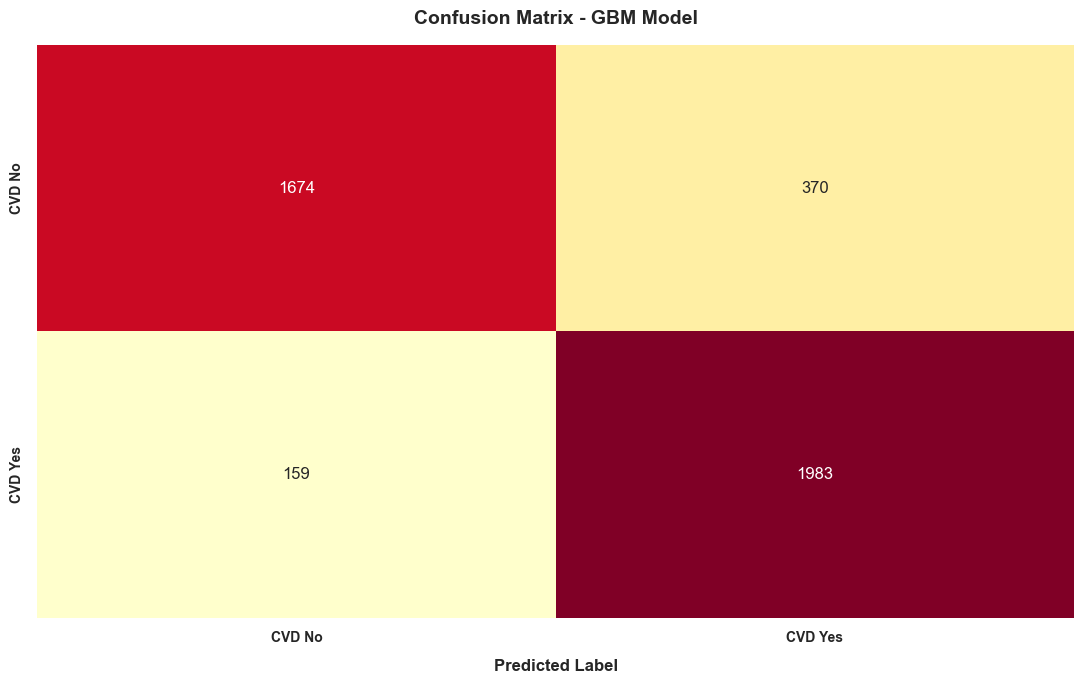

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# === Predict using the GBM model ===
y_pred_gbm = best_gbm.predict(X_test)

# === Compute confusion matrix ===
cm = confusion_matrix(y_test, y_pred_gbm)
labels = ['CVD No', 'CVD Yes']

# === Plot with seaborn heatmap ===
plt.figure(figsize=(11, 7), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels, yticklabels=labels, cbar=False)

# === Axis labels and title ===
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold', labelpad=10)
plt.xticks(rotation=0, fontsize=10, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.title('Confusion Matrix - GBM Model', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

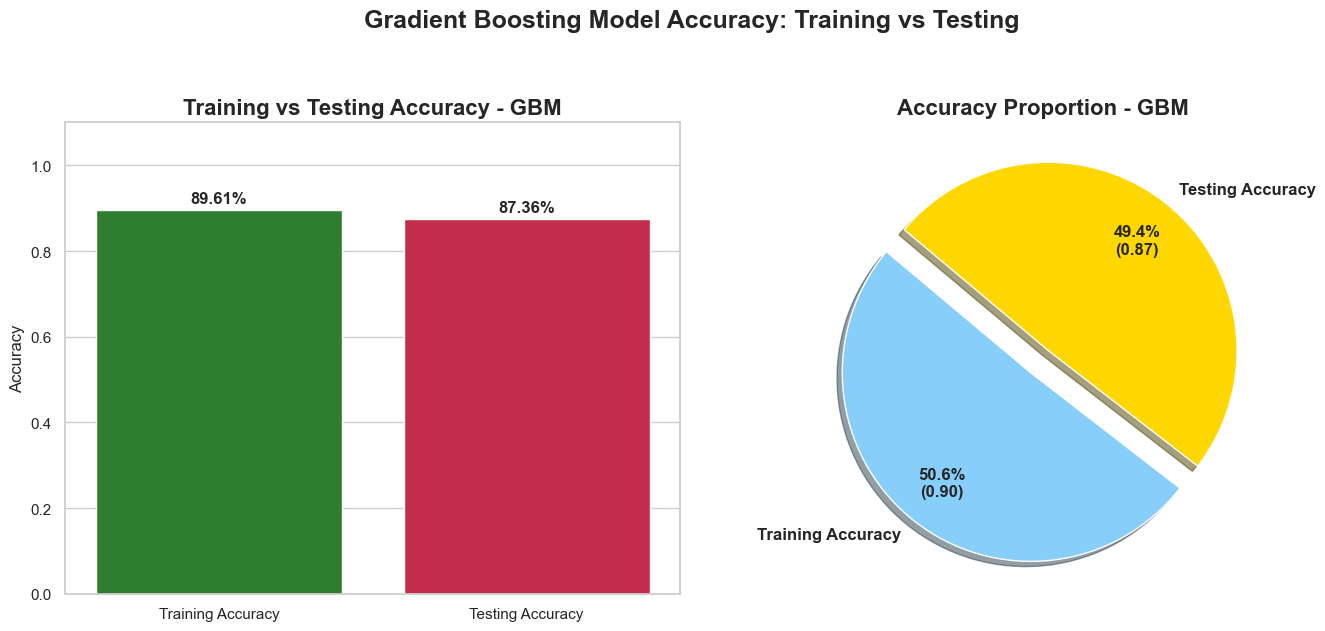

In [17]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Compute Training and Testing Accuracy ===
train_acc_gbm = accuracy_score(y_train, best_gbm.predict(X_train))
test_acc_gbm = accuracy_score(y_test, best_gbm.predict(X_test))

# === Create DataFrame for plotting ===
acc_df_gbm = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc_gbm, test_acc_gbm]
})

# === Define custom color palette ===
bar_colors = ['#228B22', '#DC143C']  # ForestGreen and Crimson
pie_colors = ['#87CEFA', '#FFD700']  # LightSkyBlue and Gold
explode = (0.1, 0.05)  # Slight explode for emphasis

# === Custom label formatting for pie chart ===
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# === Create subplots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# === Bar Chart ===
sns.barplot(x='Dataset', y='Accuracy', data=acc_df_gbm, palette=bar_colors, ax=axes[0])
for index, row in acc_df_gbm.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy - GBM', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# === Pie Chart ===
axes[1].pie(
    acc_df_gbm['Accuracy'],
    labels=acc_df_gbm['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df_gbm['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion - GBM', fontsize=16, fontweight='bold')

# === Overall Title and Layout ===
fig.suptitle('Gradient Boosting Model Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


#### Model Interpretablity Using SHAP

 99%|===================| 16531/16740 [01:06<00:00]        

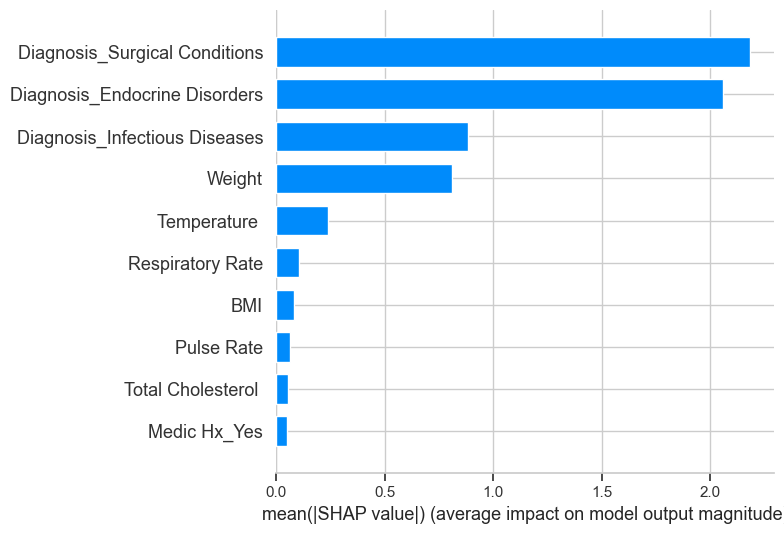

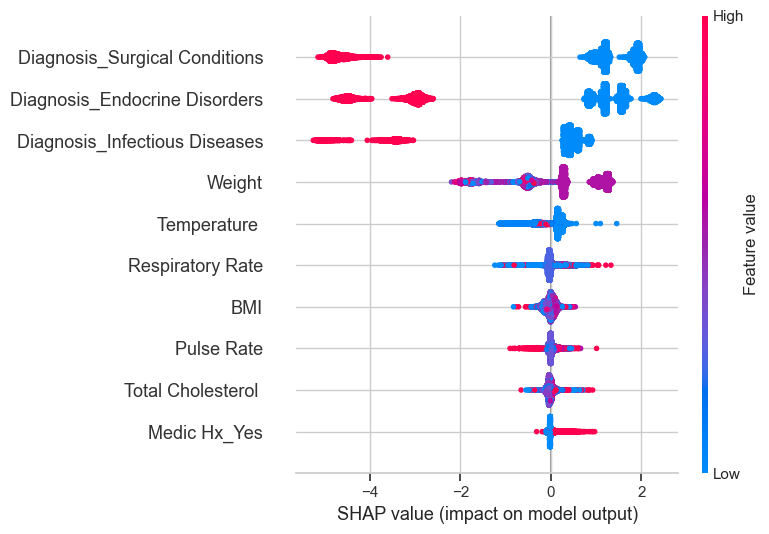

In [18]:
# ✅ Required Libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure X_train is a DataFrame
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# ✅ Create SHAP Explainer for GBM model
explainer = shap.Explainer(best_gbm, X_train_df)

# ✅ Compute SHAP values
shap_values = explainer(X_train_df)

# ✅ Plot SHAP summary bar plot (Top 10 features)
shap.summary_plot(shap_values, X_train_df, plot_type="bar", max_display=10)

# ✅ Optional: SHAP summary dot plot
shap.summary_plot(shap_values, X_train_df, max_display=10)

# ✅ Optional: Force plot for the first instance (requires Jupyter)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_train_df.iloc[0])


#### Model Interpretablity Using LIME

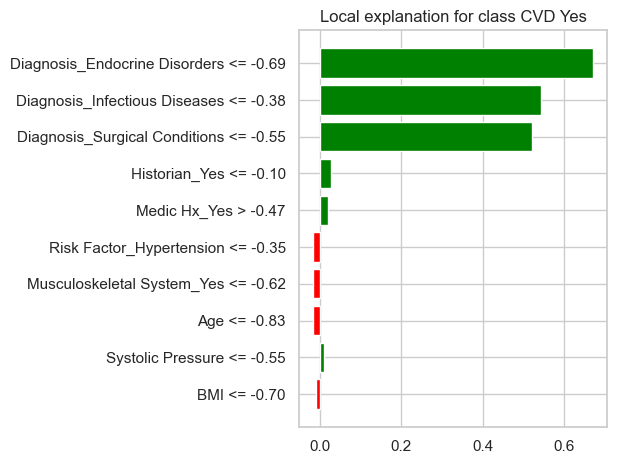

In [20]:
# ✅ Required Libraries
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure X_train is a DataFrame with column names
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# ✅ Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    X_test_df = X_test.copy()

# ✅ Create LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=X_train_df.columns.tolist(),
    class_names=['CVD No', 'CVD Yes'],
    mode='classification'
)

# ✅ Select instance to explain
i = 25  # change this index to explain a different test instance
exp = lime_explainer.explain_instance(
    data_row=X_test_df.iloc[i].values,
    predict_fn=best_gbm.predict_proba,
    num_features=10
)

# Static visualization with matplotlib
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


# ✅ Save explanation as HTML (optional)
exp.save_to_file("lime_gbm_explanation.html")


### Implementing Deep Learning Algorthim